In [119]:
import cv2
import csv

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '${:,.10f}'.format

from scipy.misc import imread, imresize
from sklearn.utils import shuffle
from os import listdir
from os.path import join
from keras.preprocessing.image import img_to_array, load_img

%matplotlib inline

In [134]:
###### TRAINING CONSTANTS ######
SPLIT = 0.5
BATCH_SIZE = 128
EPOCHS = 8
VAL_SAMPLES = 2000
SAMPLES_PER_EPOCH = (20000//BATCH_SIZE)*BATCH_SIZE
############################

In [135]:
data = pd.read_csv('../../data/driving_log_clean.csv')

In [136]:
# Shuffling the data
data = data.sample(frac=1).reset_index(drop=True)

# Dropping some of the data to balance the dataset
bad = 0
for index1, row1 in data.iterrows():
    if row1['steering'] == 0:
        bad += 1
ind = []
for index, row in data.iterrows():
    if row['steering'] == 0:
        ind.append(index)
        bad -= 1
    if bad == 750:
        break
data = data.drop(data.index[ind]).reset_index(drop=True)


# Splitting the data: (See SPLIT under SOME CONSTANTS)
train_num = int(data.shape[0]*SPLIT)
training_data = data.loc[0:train_num-1]
validation_data = data.loc[train_num:]

In [137]:
print("Full Data Size: ", data.shape)
print("Split Rate: ", SPLIT)
print("Training Data Size: ", training_data.shape)
print("Validation Data Size: ", validation_data.shape)

Full Data Size:  (6702, 4)
Split Rate:  0.5
Training Data Size:  (3351, 4)
Validation Data Size:  (3351, 4)


In [138]:
data = None

In [139]:
def visualize_distribution(data):
    num_bins = 23
    avg_samples_per_bin = len(data)/num_bins
    hist, bins = np.histogram(data, num_bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(data), np.max(data)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
    plt.show()

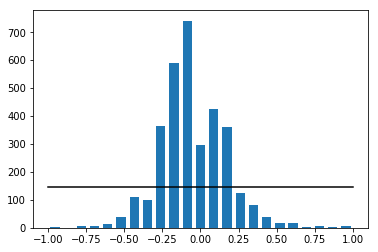

In [140]:
visualize_distribution(training_data['steering'])

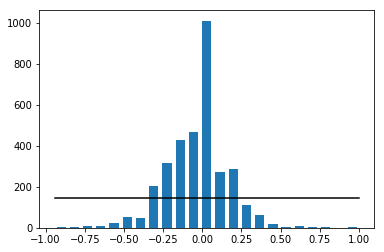

In [141]:
visualize_distribution(validation_data['steering'])

In [142]:
def resize(img, shape=(64, 64, 3)):
    cropped_image = img[55:135, :, :]
    #processed_image = imresize(cropped_image, shape)
    return cropped_image

def rgb2gray(img):
    ret = np.zeros(img.shape)
    ret = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return ret
    
def normalize(img):
    img = (img / 255) - 0.5
    return img

def preprocess(img):
    img1 = resize(img)
    img2 = rgb2gray(img1)
    img3 = normalize(img2)
    return img3

def augment_brightness(img):
    newimg = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

    # randomly generate the brightness reduction factor
    # Add a constant so that it prevents the image from being completely dark
    random_bright = .30+np.random.uniform()

    # Apply the brightness reduction to the V channel
    newimg[:,:,2] = newimg[:,:,2]*random_bright

    # convert to RBG again
    newimg = cv2.cvtColor(newimg,cv2.COLOR_HSV2RGB)
    return newimg

def read(row):
    steering = row['steering']

    camera = np.random.choice(['center', 'right', 'left'])

    if camera == 'Left':
        steering += 0.25
    elif camera == 'Right':
        steering -= 0.25

    img = imread(row[camera])

    coin = np.random.randint(0,1)

    if coin:
        steering = -1*steering
        img = cv2.flip(img, 1)

    img = augment_brightness(img)
    img = preprocess(img)

    return img, steering

[[-0.28823529 -0.30392157 -0.30392157 ...,  0.07647059  0.07647059
   0.06862745]
 [-0.3        -0.31176471 -0.31960784 ...,  0.10392157  0.04901961
   0.12352941]
 [-0.31176471 -0.31176471 -0.31176471 ...,  0.08823529  0.10784314
  -0.01764706]
 ..., 
 [-0.02156863 -0.04901961 -0.09215686 ..., -0.1627451  -0.19019608
  -0.20980392]
 [-0.11176471 -0.13529412 -0.17058824 ..., -0.15098039 -0.15882353
  -0.17058824]
 [-0.19411765 -0.20588235 -0.21764706 ..., -0.14705882 -0.13137255
  -0.12352941]]
(80, 320)
(80, 320, 1)
0.3009732


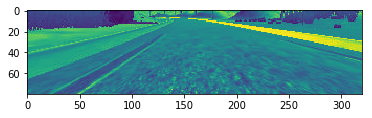

In [148]:
idx = np.random.randint(0, training_data.shape[0]-1)

row = training_data.iloc[idx]

x = np.zeros((80, 320, 1), dtype=np.float32)
y = np.zeros((), dtype=np.float32)
x, y = read(row)
print(x)
print(x.shape)
plt.imshow(x)
x = x.reshape(x.shape[0], x.shape[1], 1)
print(x.shape)
print(y)